In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
import html
import urllib

Reading data
------------

In [34]:
graphs_path = './data/wikispeedia_paths-and-graph/'

In [35]:
!ls data/wikispeedia_paths-and-graph/

articles.tsv	links.tsv	    paths_unfinished.tsv
categories.tsv	paths_finished.tsv  shortest-path-distance-matrix.txt


In [25]:
!head './data/wikispeedia_paths-and-graph/categories.tsv'

# Hierarchical categories of all articles.
# Many articles have more than one category. Some articles have no category.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   article   category
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:


In [26]:
def read_tsv(file_name, names=None):
    
    file_path = graphs_path + f'{file_name}.tsv'
    
    if not names:
        with open(file_path, 'r') as file:
            for line in file:
                if 'FORMAT' in line:
                    format_line = line
                    break

        names = format_line.split()[2:]
    
    return pd.read_csv(file_path,
                           delimiter='\t', comment='#', header=0, names=names)

In [95]:
link_network = read_tsv('links', names=['source', 'target'])
display(link_network.head(5))
link_network.shape

# link_network = link_network.applymap(urllib.parse.unquote_plus).copy()

,source,target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man


(119881, 2)

In [96]:
categories = read_tsv('categories')
display(categories.head(5))
categories.shape


,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
1,%C3%85land,subject.Countries
2,%C3%85land,subject.Geography.European_Geography.European_...
3,%C3%89douard_Manet,subject.People.Artists
4,%C3%89ire,subject.Countries


(5203, 2)

In [97]:
finished_paths = read_tsv('paths_finished')
display(finished_paths.head(5))
finished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,rating
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN


(51317, 5)

In [98]:
unfinished_paths = read_tsv('paths_unfinished')
display(unfinished_paths.head(5))
unfinished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
1,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
2,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
3,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
4,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout


(24874, 6)

In [99]:
articles = read_tsv('articles')
display(articles.head(5))
articles.shape

,article
0,%C3%85land
1,%C3%89douard_Manet
2,%C3%89ire
3,%C3%93engus_I_of_the_Picts
4,%E2%82%AC2_commemorative_coins


(4603, 1)

Pre-processing
--------------

In [49]:
# count number of incoming and outgoing links

source_counts = link_network['source'].value_counts().rename_axis('article').reset_index(name='source_count')
target_counts = link_network['target'].value_counts().rename_axis('article').reset_index(name='target_count')

link_counts = pd.merge(source_counts, target_counts, how='outer')
link_counts.fillna(0, inplace=True)

In [104]:
link_counts['target_source_ratio'] = link_counts['target_count'] / link_counts['source_count']
link_counts['target_source_ratio'].replace([np.inf], np.nan, inplace=True)

display(link_counts.head(5))
link_counts.shape

,article,source_count,target_count,target_source_ratio
0,United_States,294.0,1551.0,5.275510
1,Driving_on_the_left_or_right,255.0,0.0,0.000000
2,List_of_countries,244.0,63.0,0.258197
3,List_of_circulating_currencies,236.0,8.0,0.033898
4,List_of_sovereign_states,216.0,43.0,0.199074


(4592, 4)

In [193]:
import uuid
import os
import urllib.parse
from bs4 import BeautifulSoup, Comment

def gen_uniq_str(str_):
    return uuid.uuid4().hex[:len(str_)+1]

def find_html_position(source, targets):
    article_quote = source
    with open('data/wpcd/wp/{}/{}.htm'.format(article_quote[0].lower(), article_quote)) as f:
        try:
            art_html = f.read()
        except:
            print(source)
            return -1

    soup = BeautifulSoup(art_html, features="html.parser")
    for script in soup(["script", "style", "head"]):
        script.extract()    # rip it out

    comments = soup.findAll(string=lambda string:isinstance(string, Comment))
    for comment in comments:
        comment.extract()
        
    locators = []
    
    for tgt in targets:
        try:
            locator = gen_uniq_str(urllib.parse.unquote_plus(tgt))
            locators.append(locator)
            #soup.find('a', attrs={'title': tgt.replace("_", " ")}).replace_with(locator)
            
            soup.select_one(f'a[href*="/{urllib.parse.quote_plus(tgt)}.htm"]').replace_with(locator)
        except Exception as e:
            k = f'a[href*="{urllib.parse.quote_plus(tgt)}.htm"]'
            print(k)
            print(source, tgt)
            pass
    
    text = " ".join(soup.text.split())
    
    pos = {}
    for iloc, loc in enumerate(locators):
        pos[targets[iloc]] = text.find(loc)/len(text)
        
    return pos


In [184]:
with open("data/wpcd/wp/1/11th_century.htm") as fp:
    soup = BeautifulSoup(fp, 'html.parser')
    
for script in soup(["script", "style", "head"]):
    script.extract()    # rip it out

comments = soup.findAll(string=lambda string:isinstance(string, Comment))
for comment in comments:
    comment.extract()
    
soup.select_one('a[href*="Nigeria.htm"]').replace_with("sdf")
soup.select_one('a[href*="Norman_conquest_of_England.htm"]')

<a href="../../wp/n/Norman_conquest_of_England.htm" title="Norman conquest of England">Norman conquest of England</a>

In [185]:
row = link_network_targets.query('source == "11th_century"').iloc[0]
find_html_position(row['source'], row['target'])

{'10th_century': 0.021573604060913704,
 '12th_century': 0.025944726452340666,
 '13th_century': 0.9242808798646363,
 '14th_century': 0.9262549351381839,
 '15th_century': 0.9282289904117316,
 '16th_century': 0.9302030456852792,
 '17th_century': 0.9321771009588269,
 '18th_century': 0.9341511562323745,
 '19th_century': 0.9361252115059222,
 '1st_century': 0.9049633389734912,
 '1st_century_BC': 0.9020022560631697,
 '20th_century': 0.9380992667794699,
 '21st_century': 0.9407783417935702,
 '2nd_century': 0.9067963902989283,
 '3rd_century': 0.9086294416243654,
 '4th_century': 0.9104624929498026,
 '5th_century': 0.9122955442752397,
 '6th_century': 0.9141285956006768,
 '7th_century': 0.9159616469261139,
 '8th_century': 0.917794698251551,
 '9th_century': 0.9196277495769881,
 'Battle_of_Hastings': 0.37408347433728145,
 'Byzantine_Empire': 0.20727580372250423,
 'Canute_the_Great': 0.6603214890016921,
 'China': 0.7329385222786238,
 'Crusades': 0.14438804286520024,
 'Dark_Ages': 0.1042019176536943,
 '

In [194]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

link_network = filter_rows_by_values(link_network, 'source', ['Friend_Directdebit', 'Sponsorship_Directdebit'])
link_network_targets = link_network.groupby('source')['target'].apply(list).reset_index()

In [195]:
# Add the 'html_position' column to the DataFrame
link_network_targets['html_position'] = link_network_targets.apply(
    lambda row: find_html_position(row['source'], row['target']), axis=1
)


a[href*="Genghis_Khan.htm"]
Genghis_Khan Genghis_Khan
a[href*="Germany.htm"]
List_of_European_Union_member_states_by_accession Germany
a[href*="Ireland.htm"]
List_of_European_Union_member_states_by_accession Ireland


In [196]:
display(link_network_targets.head(5))
link_network_targets.shape

,source,target,html_position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[Columba, D%C3%A1l_Riata, Great_Britain, Irela...","{'Columba': 0.0374586852735953, 'D%C3%A1l_Riat..."
1,%C3%85land,"[20th_century, Baltic_Sea, Crimean_War, Curren...","{'20th_century': 0.4077241923810777, 'Baltic_S..."
2,%C3%89douard_Manet,"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1...","{'Absinthe': 0.11527492584987452, 'Beer': 0.60..."
3,%C3%89ire,"[Canada, English_language, George_VI_of_the_Un...","{'Canada': 0.4879246498148446, 'English_langua..."
4,%C3%93engus_I_of_the_Picts,"[D%C3%A1l_Riata, Durham, England, Great_Britai...","{'D%C3%A1l_Riata': 0.08427483471420202, 'Durha..."


(4585, 3)

In [208]:
m = pd.DataFrame([*link_network_targets['html_position']], link_network_targets.index).stack()\
      .rename_axis([None,'target']).reset_index(1, name='position')

link_network_pos = link_network_targets[['source']].join(m)

In [209]:
link_network_pos = pd.merge(link_network, link_network_pos, on=['source', 'target'], how='left')
link_network_pos.to_pickle('link_network_w_position.df')
display(link_network_pos.head(5))
link_network_pos.shape

,source,target,position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,0.037459
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,0.025523
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,0.058024
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,0.032042
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,0.063349


(119878, 3)

In [221]:
def calculate_positions(arts):
    if '<' in arts: return [float('nan')]
    articles = arts.split(';')
    
    if len(articles) < 2: return [float('nan')]
    
    positions = []
    
    art_idx = 0
    
    for idx, art in enumerate(articles[1:]):
        art0 = articles[art_idx]
        try:          
            positions.append(link_network_pos[(link_network_pos['source'] == art0)
                            & (link_network_pos['target'] == art)]['position'].values[0])
            art_idx = idx+1
        except:
            print(art0, art, arts)
            return [float('nan')]
    
    return positions

In [222]:
finished_paths['link_positions'] = finished_paths['path'].apply(calculate_positions)
unfinished_paths['link_positions'] = unfinished_paths['path'].apply(calculate_positions)

Bird Wikipedia_Text_of_the_GNU_Free_Documentation_License Bird;Wikipedia_Text_of_the_GNU_Free_Documentation_License
Finland %C3%85land Euro;Finland;%C3%85land;Baltic_Sea;Atlantic_Ocean;Whale
Republic_of_Ireland %C3%89ire Democratic_Action_Party;Parliament_of_Malaysia;United_Kingdom;Republic_of_Ireland;%C3%89ire;Canada;Vancouver;North_America;Florida;Fruit
Claude_Monet %C3%89douard_Manet The_Cantos;Renaissance;Leonardo_da_Vinci;Mona_Lisa;Oil_painting;Impressionism;Claude_Monet;%C3%89douard_Manet;Diego_Vel%C3%A1zquez;Francisco_Goya;Printmaking
Republic_of_Ireland %C3%89ire Government_of_France;France;European_Union;Republic_of_Ireland;%C3%89ire
Impressionism %C3%89douard_Manet Mahatma_Gandhi;New_York_City;Culture;Literature;Fiction;Art;Expressionism;Impressionism;%C3%89douard_Manet;Edgar_Allan_Poe;Employment;Wikipedia_Text_of_the_GNU_Free_Documentation_License
Basilica_of_Santa_Maria_degli_Angeli Wikipedia_Text_of_the_GNU_Free_Documentation_License Basilica_of_Santa_Maria_degli_Angeli;Wi

Georgia_%28country%29 Wikipedia_Text_of_the_GNU_Free_Documentation_License Jesus;Mosaic;Georgia_%28country%29;Wikipedia_Text_of_the_GNU_Free_Documentation_License
Jesus Wikipedia_Text_of_the_GNU_Free_Documentation_License Jesus;Wikipedia_Text_of_the_GNU_Free_Documentation_License
Bronze_Age Wikipedia_Text_of_the_GNU_Free_Documentation_License Axe;Bronze_Age;Wikipedia_Text_of_the_GNU_Free_Documentation_License


In [232]:
get_avg_duration = lambda row: row['durationInSec'] / len(row['path'].split(';'))
finished_paths['avg_duration'] = finished_paths.apply(get_avg_duration, axis=1)
unfinished_paths['avg_duration'] = unfinished_paths.apply(get_avg_duration, axis=1)

In [234]:
finished_paths['avg_position'] = finished_paths['link_positions'].apply(
    lambda x: np.mean(x) if x else np.nan)
unfinished_paths['avg_position'] = unfinished_paths['link_positions'].apply(
    lambda x: np.mean(x) if x else np.nan)

finished_paths['max_position'] = finished_paths['link_positions'].apply(
    lambda x: np.max(x) if x else np.nan)
unfinished_paths['max_position'] = unfinished_paths['link_positions'].apply(
    lambda x: np.max(x) if x else np.nan)

Preliminary analysis
-----------------------------

In [236]:
link_counts.describe()

,source_count,target_count,target_source_ratio
count,4592.000000,4592.000000,4587.000000
mean,26.106490,26.106490,0.859391
std,24.196551,62.814634,1.439986
min,0.000000,0.000000,0.000000
25%,11.000000,2.000000,0.166667
50%,19.000000,8.000000,0.470588
75%,33.000000,25.000000,1.040213
max,294.000000,1551.000000,42.250000


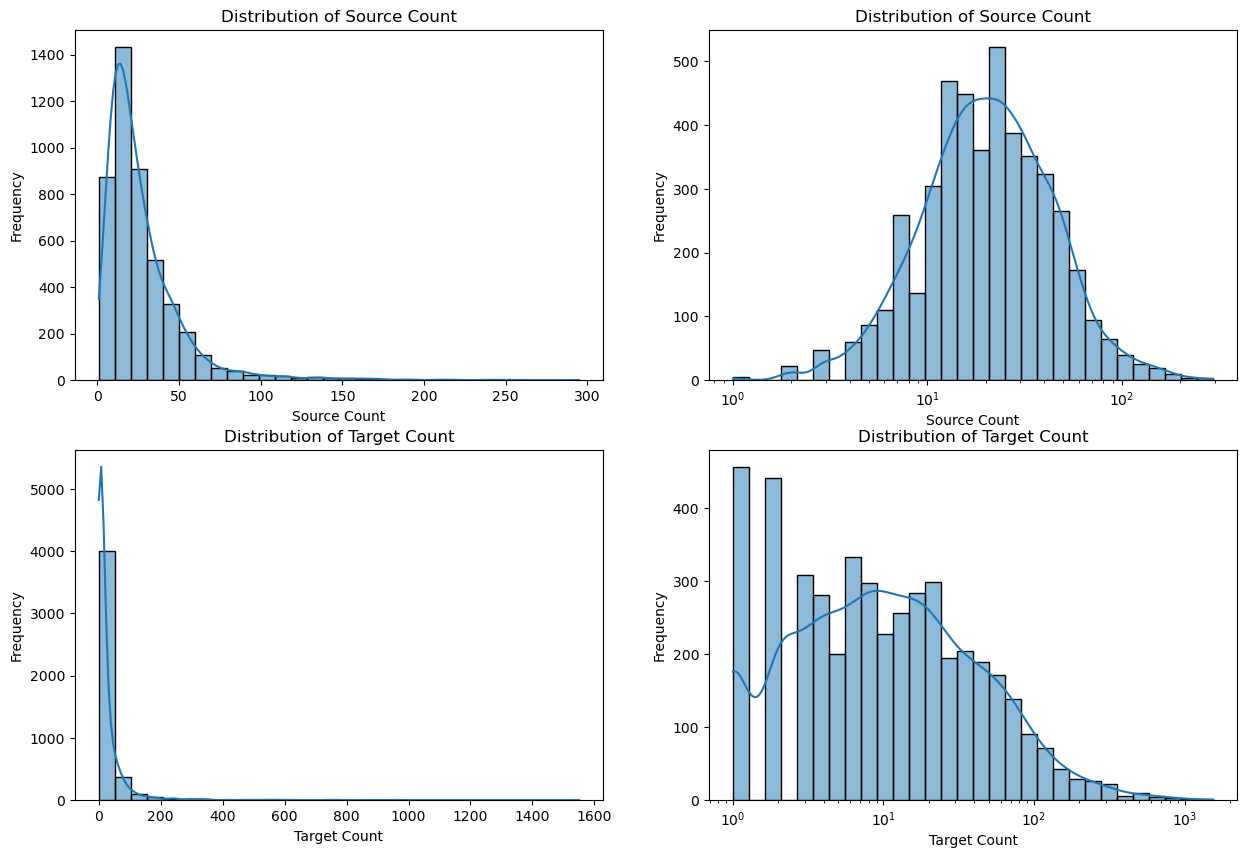

In [243]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

ax = axs[0, 0]

sns.histplot(link_counts['source_count']+1, bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Source Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Source Count')

ax = axs[0, 1]

sns.histplot(link_counts['source_count']+1, bins=30, kde=True, log_scale=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Source Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Source Count')

ax = axs[1, 0]

sns.histplot(link_counts['target_count'], bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Count')


ax = axs[1, 1]

sns.histplot(link_counts['target_count']+1, bins=30, kde=True, log_scale=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target Count')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Count')

plt.show()


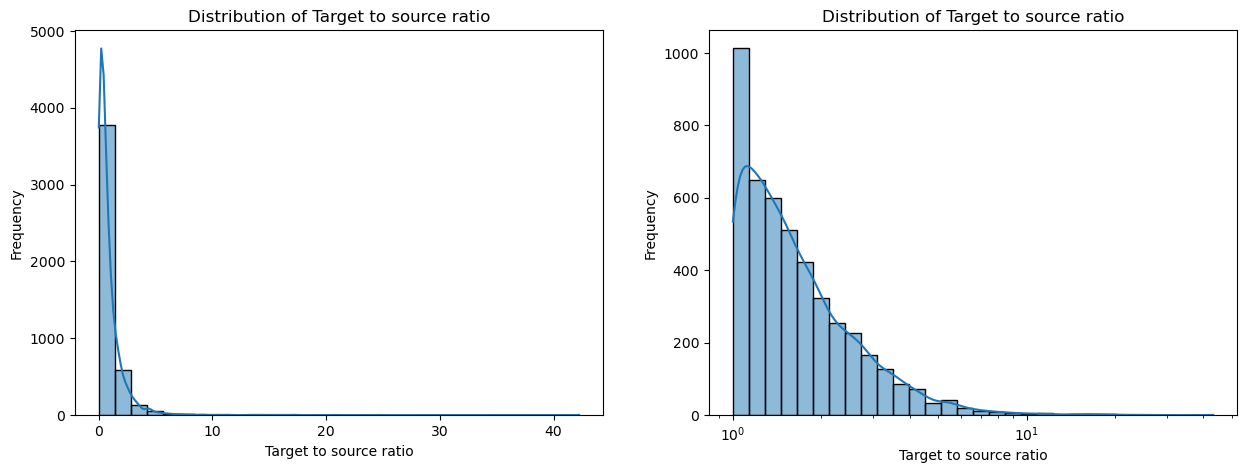

In [260]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

ax = axs[0]

sns.histplot(link_counts['target_source_ratio'], bins=30, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target to source ratio')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target to source ratio')

ax = axs[1]

sns.histplot(link_counts['target_source_ratio']+1, bins=30, log_scale=True, kde=True, ax=ax)  # Create a histogram with a kernel density estimate
ax.set_xlabel('Target to source ratio')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target to source ratio')

plt.show()

In [228]:
link_network_pos.describe()

,position
count,119878.000000
mean,0.405405
std,0.318017
min,-0.000080
25%,0.098042
50%,0.351382
75%,0.689618
max,0.995548


In [235]:
finished_paths.describe()

,timestamp,durationInSec,rating,avg_duration,avg_position,max_position
count,5.131700e+04,51317.000000,28501.000000,51317.000000,42307.000000,42307.000000
mean,1.296384e+09,158.276049,2.269780,22.352658,0.265564,0.592498
std,4.935134e+07,360.845419,1.110439,49.920621,0.154535,0.283027
min,1.219095e+09,0.000000,1.000000,0.000000,0.001663,0.001663
25%,1.250109e+09,60.000000,1.000000,11.571429,0.148665,0.364372
50%,1.283894e+09,107.000000,2.000000,17.461538,0.249552,0.638645
75%,1.345232e+09,183.000000,3.000000,26.000000,0.357770,0.845849
max,1.389823e+09,35091.000000,5.000000,4665.200000,0.988849,0.994416
